# Variational AutoEncoder

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from craynn import *
from craynn.viz import draw_to_notebook, SimpleWatcher

## MNIST data

In [2]:
data_train, _, _, _ = utils.mnist(root='./data', one_hot=True, cast='float32')

In [3]:
session = get_gpu_session(memory_fraction=0.5)

In [4]:
X_train, = variable_dataset(session, data_train).batch(32)

## Network definition

In [5]:
encoder = net((None, 28, 28, 1))(
    conv(16), conv(24), max_pool(),
    conv(32), conv(48), max_pool(),
    conv(64), max_pool(),
    [ conv_1x1(96, activation=linear()), conv_1x1(96, activation=softplus()) ]
)

decoder = net((None, 1, 1, 96))(
    upscale(), deconv(64),
    upscale(), deconv(48), deconv(32),
    upscale(), deconv(24), deconv(1),
)

ae = net((None, 28, 28, 1))(
    vae(encoder, decoder)
)

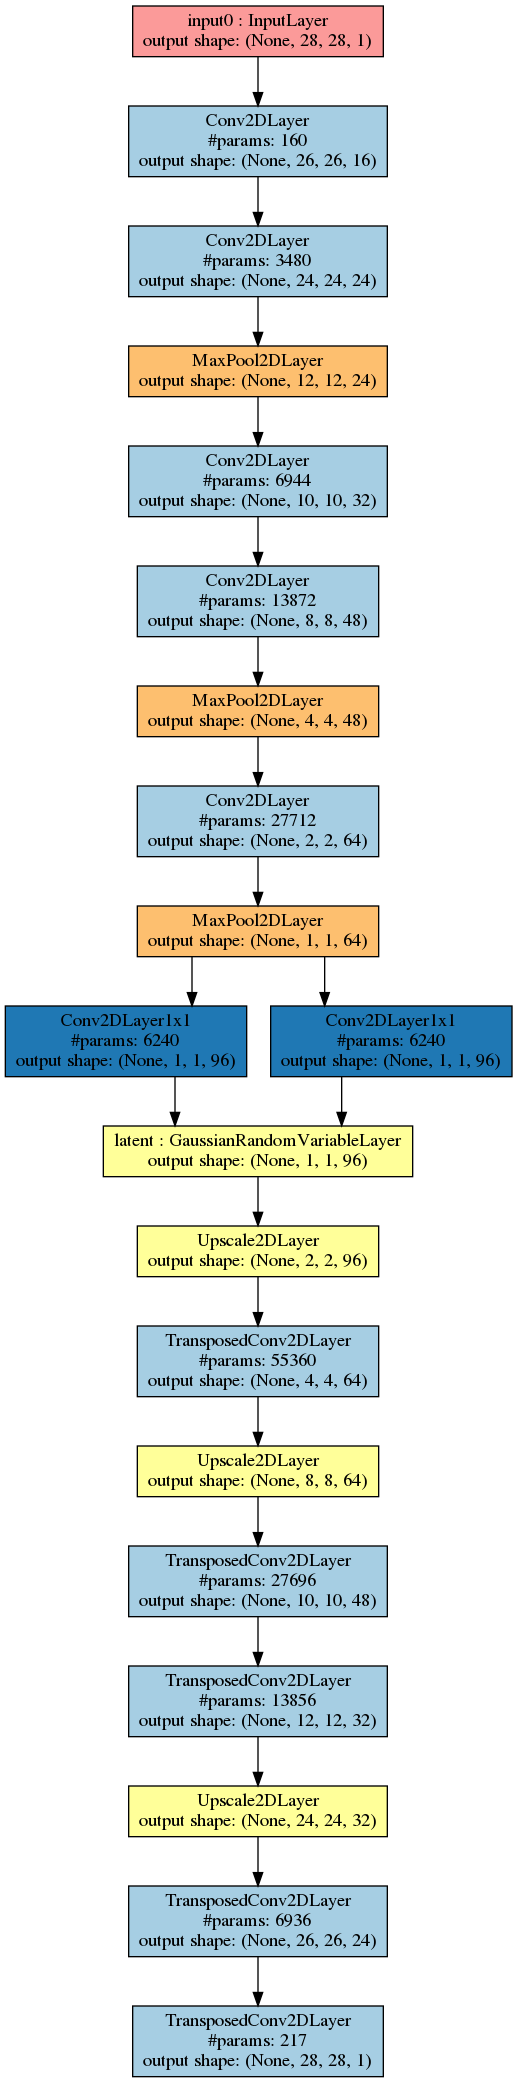

In [6]:
draw_to_notebook(ae)

In [7]:
X_reconstructed, code_mean, code_std = ae(X_train)

In [8]:
loss = objectives.elbo_norm(X_train, X_reconstructed, code_mean, code_std, sigma_reconstructed=0.1)

In [9]:
optimizer = tf_updates.adam()(loss, ae.variables())
updates = optimizer.updates()

In [10]:
session.run([ae.reset(), optimizer.reset()])

[None, None]

### Training

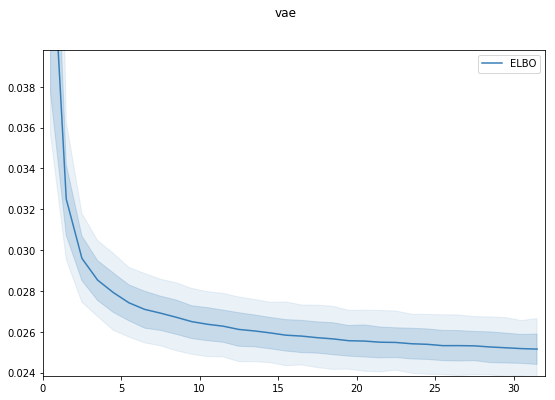

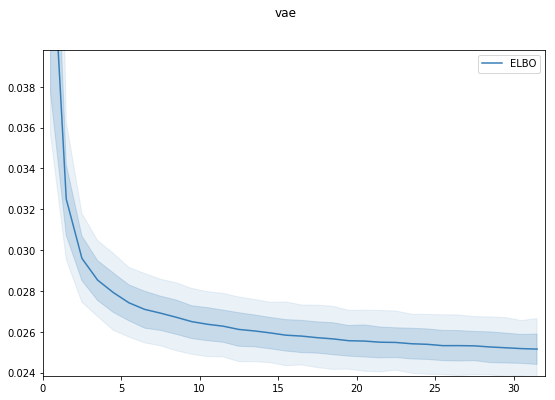

In [11]:
n_epoches = 32
n_batches = data_train.shape[0] // 32

losses = np.zeros((n_epoches, n_batches), dtype='float32')

watcher = SimpleWatcher(title='vae', labels=('ELBO', 'losses val'))

for i in range(n_epoches):
    for j in range(n_batches):
        _, losses[i, j] = session.run([ updates, loss ])
    
    watcher.draw(losses[:(i + 1)])

## Sampling

In [12]:
z_custom = tf.placeholder(shape=(None, 1, 1, 96), dtype='float32')

X_gen, = decoder(z_custom)

In [13]:
imgs = session.run(X_gen, feed_dict={ z_custom : np.random.normal(size=(25, 1, 1, 96)) })

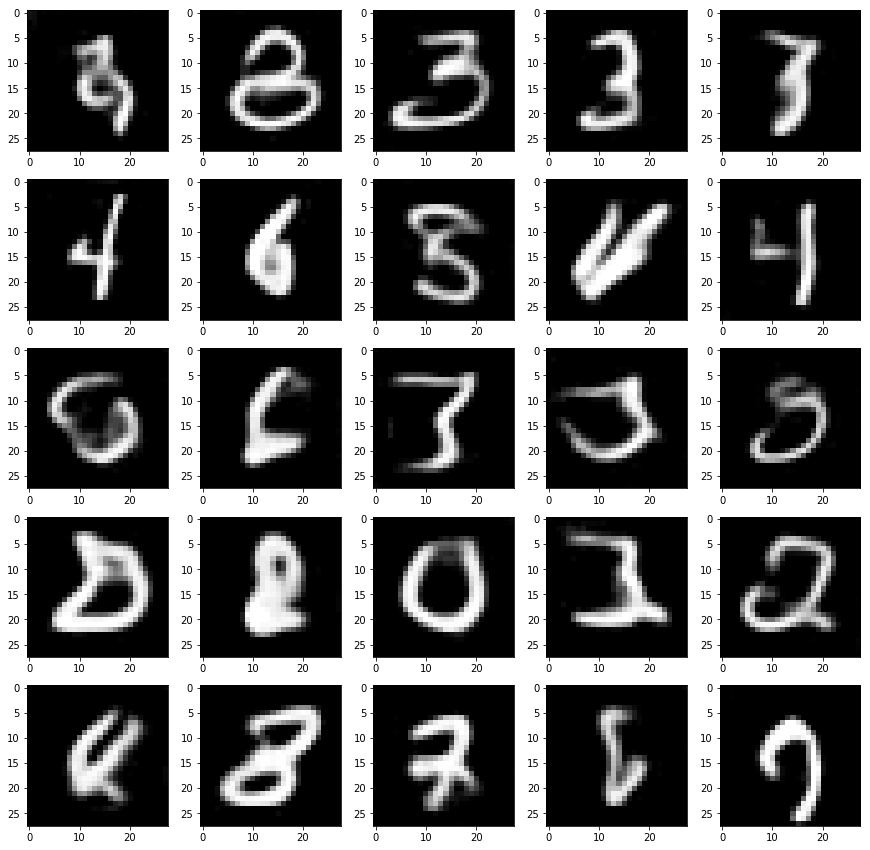

In [14]:
plt.subplots(5, 5, figsize=(15, 15))

for i in range(5):
    for j in range(5):
        k = i * 5 + j
        plt.subplot(5, 5, k + 1)
        plt.imshow(imgs[k, :, :, 0], cmap=plt.cm.gray, vmax=1.0, vmin=0.0)